# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was recently proposed by [3].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_test:  (1000,)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)


## Batch normalization: Forward
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

In [9]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [ 27.18502186  34.21455511  37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [  4.21884749e-17   5.10702591e-17  -3.51801921e-17]
  std:  [ 0.99999999  1.          1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999999]


In [10]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

(array([[  3.20851609e-01,   1.68899962e+00,   9.33484494e-01],
        [  7.79123179e-01,  -1.15861550e+00,   9.32868947e-01],
        [  1.18360971e+00,  -2.46148789e+00,  -8.22937393e-01],
        [  1.25651413e-01,   1.02258854e+00,  -8.50080532e-01],
        [ -1.11262810e+00,   2.20021669e-01,  -2.02643324e+00],
        [  9.01178404e-01,   2.59056900e-01,   1.45590719e-02],
        [  5.52016037e-01,   3.71287014e-01,   6.21544673e-01],
        [ -1.18403401e+00,  -6.24310406e-01,   2.13643348e-01],
        [  1.71998183e+00,  -1.40221164e+00,  -1.63385695e+00],
        [ -8.02992629e-01,   3.18406879e-01,   4.15933923e-02],
        [  1.54641572e+00,  -2.04150177e-03,   2.42122487e-01],
        [  1.50745669e-02,  -2.20053646e+00,  -1.14552492e+00],
        [  2.52323497e-01,  -3.40284343e-01,   1.01082900e+00],
        [  5.54719940e-01,  -2.30495659e-01,  -1.37453367e-01],
        [  9.03656230e-01,   6.28997222e-01,   1.59432397e+00],
        [ -1.50214176e+00,   1.34240955e

(array([[  2.51662407e-01,   3.33253370e-01,   2.92326621e-01],
        [  6.79018290e-01,   6.24688730e-01,   7.11381139e-01],
        [ -1.99256423e-02,  -1.33182314e-01,  -8.31960841e-01],
        [ -2.14787298e+00,  -1.04650530e+00,  -4.10608102e-01],
        [  6.85816935e-02,   1.98177138e+00,  -4.90338762e-01],
        [  9.42985377e-02,   8.05675791e-01,   6.32982042e-01],
        [ -1.65895740e-01,  -7.31675778e-01,  -6.40697962e-01],
        [ -5.42015873e-01,  -1.66092551e+00,  -2.79596784e+00],
        [ -7.90968349e-01,   5.58942893e-01,  -8.72305991e-01],
        [ -1.44190606e+00,   6.13530486e-01,   1.30871538e+00],
        [  4.40842723e-01,   4.97819531e-01,   7.57740371e-01],
        [  8.50005260e-01,  -1.58736868e+00,  -6.89964167e-01],
        [ -8.49894704e-03,   1.60984501e+00,   3.00577072e-01],
        [ -1.58925300e-01,  -6.84804270e-01,  -1.50818396e+00],
        [ -4.76050344e-01,   2.15177256e+00,   5.34942751e-01],
        [  1.43827806e+00,   1.21990723e

(array([[  1.28933236e-01,   7.88070290e-01,   1.16701021e+00],
        [ -1.90101506e+00,  -5.73739854e-01,  -2.85815634e-01],
        [  1.17027046e+00,  -4.13524439e-01,   7.77991176e-01],
        [  7.72174738e-01,  -1.28065399e+00,   3.45260393e-02],
        [ -6.73308585e-01,  -8.69155423e-01,  -8.00583468e-01],
        [ -8.44813453e-01,   5.76718840e-01,  -8.81970862e-01],
        [ -1.61414124e+00,  -1.82977977e-01,  -1.23810735e-01],
        [ -3.89221253e-01,  -3.33412779e+00,  -6.88775960e-01],
        [ -7.45262310e-01,  -2.24561453e-01,   1.10353069e+00],
        [ -2.36964357e-01,  -2.92637764e-01,   1.01801097e-01],
        [ -2.94992912e-02,   1.12674659e+00,   9.72914942e-03],
        [  9.96161683e-02,   8.46433346e-01,   7.30561760e-03],
        [  3.84263339e-01,   4.17177300e-01,  -7.42547353e-02],
        [  5.76954017e-01,   1.12422014e-01,   4.73061159e-01],
        [  2.45681696e+00,   3.80127376e-01,   1.16156898e+00],
        [  1.38944627e+00,   5.38483531e

(array([[ -2.18395220e-01,  -1.56581445e-01,  -2.60800198e-01],
        [ -1.41904390e+00,  -9.45656613e-01,  -8.92432758e-01],
        [  6.13367866e-01,  -5.93411155e-01,   3.30902380e-03],
        [  7.87598565e-01,  -1.27886988e+00,  -2.91076830e+00],
        [  1.17788738e+00,  -1.01435722e+00,   3.60408944e-01],
        [  7.83879753e-01,  -8.76455660e-01,   6.07924248e-01],
        [ -2.43291222e+00,   1.34628970e-01,   3.14363960e-01],
        [ -3.24202607e-01,   5.12671584e-01,   3.17060460e-01],
        [  5.00400193e-01,  -1.70653485e+00,  -9.79593889e-01],
        [ -1.05324114e+00,   4.83256393e-01,   7.85013403e-01],
        [  1.25297610e+00,  -1.63396924e+00,  -3.75009716e-01],
        [  1.27588356e+00,   5.23791151e-02,   1.18906557e+00],
        [  7.22635876e-01,   1.04275659e-02,   4.38511295e-01],
        [  2.04023621e-01,   7.75805812e-01,   2.23044866e-01],
        [ -3.70884826e-02,   1.47410041e+00,   1.65784179e+00],
        [  7.32753977e-01,  -5.09331378e

(array([[-1.17388556,  1.18503013, -0.45966754],
        [ 0.87281545,  1.03270161,  1.14223218],
        [-2.36334061, -0.38820317, -1.38458725],
        [ 0.61664957,  0.6875992 , -0.11471505],
        [ 1.07919278,  0.80129994,  1.16413365],
        [-0.83878846, -1.95231629, -0.52528061],
        [-1.22600507,  0.61842257, -1.75810125],
        [-0.38369213,  1.22058815,  1.54463581],
        [ 2.23081943, -1.82522037,  0.43356703],
        [ 0.01604229, -0.58441089,  0.14910869],
        [-0.26599321, -0.57382632, -0.81224319],
        [ 0.74879762, -0.34881385, -2.17918791],
        [-0.87429016,  0.18826623, -0.13000855],
        [-0.14459493, -0.45903234, -2.46922968],
        [ 0.83841605,  1.09547885, -1.17584988],
        [-0.92818728,  3.74013265,  0.50372562],
        [-0.99306925, -1.34599221,  0.04641984],
        [-0.4584363 ,  0.37053897,  1.23030259],
        [-1.82482738, -1.34429203, -0.87366455],
        [ 0.62309901, -0.78823751, -0.57657371],
        [-0.48744335

(array([[-0.4739219 , -0.4847796 , -1.01735314],
        [-0.65234048, -0.23394625,  0.60161514],
        [ 1.54848792,  0.34379055,  1.11252362],
        [ 0.77024646,  0.86228682,  1.73300313],
        [-0.0142156 , -0.67780313,  0.51406043],
        [ 1.22684343,  0.2475312 , -0.33315707],
        [-0.1310828 , -0.34839401,  0.6000281 ],
        [ 1.31266667,  2.6690781 ,  1.10135884],
        [ 1.12445242, -0.4223803 , -0.53195859],
        [-1.34365778, -0.35343753,  0.66195984],
        [ 1.87911965, -1.23861487, -0.57083111],
        [-0.35954912,  0.42748237,  0.49682423],
        [ 0.3159095 , -0.54044104,  2.17887684],
        [-0.66793656,  0.24474618,  0.35570383],
        [ 0.32596228,  0.43266331, -0.18762635],
        [ 0.02703455, -0.15982871,  0.03470153],
        [-0.19814828, -0.82668134,  0.30925449],
        [-2.21725326, -1.95602907,  0.24842489],
        [-0.04442594,  0.23960427, -0.22008753],
        [-0.31909752, -0.0130598 ,  0.51935552],
        [ 2.32082217

(array([[ -1.44638231e-01,  -1.76819964e+00,  -7.63880332e-01],
        [ -9.99637652e-01,  -5.34551720e-01,  -9.77084314e-01],
        [  1.39675803e+00,  -4.06320049e-02,   3.33790736e-01],
        [ -2.31466497e-01,  -2.37056325e-01,  -1.88944332e+00],
        [ -5.24359582e-01,  -6.94790198e-01,  -1.06513573e+00],
        [ -3.60005460e-01,  -9.24172371e-02,  -1.81171656e-01],
        [ -1.61717359e-01,   7.39473511e-01,  -1.98357521e+00],
        [  4.89770302e-01,   2.50790484e+00,   6.29922392e-01],
        [ -2.63301039e-01,   4.06852175e-01,  -3.75593546e-01],
        [  1.70968597e+00,   1.69345996e-01,   1.65657250e+00],
        [  1.29009317e+00,  -5.08585563e-01,   3.06853954e-01],
        [  1.85140611e+00,   6.69745095e-03,   1.65711709e+00],
        [  5.91218047e-01,   1.22477210e+00,  -3.50400879e-01],
        [ -5.31726456e-01,  -7.59129838e-01,  -4.44855153e-01],
        [  2.35184312e-01,   3.97897342e-01,  -5.49431077e-01],
        [  4.61910590e-01,  -9.06542883e

(array([[  1.02251852e+00,  -6.42234194e-02,   3.02359791e-01],
        [ -2.43707332e+00,   9.35759790e-01,  -8.25400087e-01],
        [  6.03014460e-02,   1.63703974e-01,   1.31843959e+00],
        [  1.68187674e+00,  -4.12901854e-02,   2.81810276e+00],
        [ -1.38516102e-01,  -2.73209987e+00,  -5.84947792e-01],
        [  1.49285726e+00,  -1.29560645e+00,   1.46268639e+00],
        [  6.07341043e-01,  -1.24115657e+00,  -1.47230039e+00],
        [ -7.49189523e-02,   3.22946975e-01,   3.68358169e-01],
        [ -8.71056359e-01,   4.58615666e-02,  -2.81148648e-01],
        [  1.20833296e+00,  -5.45886638e-01,   3.30641535e+00],
        [ -1.08636351e+00,  -6.49814110e-01,  -5.97990088e-01],
        [ -1.44467336e+00,  -1.19492732e+00,  -2.97752465e-01],
        [  6.08474573e-01,   1.51597173e+00,   2.52643087e+00],
        [ -7.86431954e-01,   2.07107431e+00,  -9.03828220e-01],
        [ -7.96237450e-01,  -4.63480335e-01,  -5.78736279e-01],
        [ -9.95976615e-01,   4.92572457e

(array([[  5.63474003e-01,  -1.12960392e+00,  -7.36175899e-01],
        [  2.48565370e-01,   2.09773225e-01,  -2.30891013e-01],
        [ -1.00912072e-01,  -4.77316766e-01,  -1.66989187e-01],
        [ -2.98485669e-01,   2.06083211e+00,   1.32445699e+00],
        [ -9.21067159e-01,   4.55815493e-01,   2.42366084e-01],
        [  4.83307587e-01,   1.02699223e+00,   2.90163254e-01],
        [ -7.30310251e-01,   1.53225771e+00,  -5.06075376e-01],
        [  3.27367564e-01,   6.42056392e-01,   1.27898214e-01],
        [ -1.64142252e+00,   6.67558013e-01,   1.56650272e-01],
        [  1.76394319e-01,  -1.18519133e+00,  -6.75368985e-01],
        [  2.52757651e-01,  -1.57840444e+00,  -6.86217647e-01],
        [ -1.28708814e+00,   1.11083639e+00,  -1.46631576e+00],
        [ -2.54257875e-01,   2.31764628e-01,  -1.01165537e+00],
        [ -1.20472750e+00,  -1.48132625e-01,  -9.84420061e-01],
        [ -2.06630556e+00,   1.04768584e+00,  -1.08323631e+00],
        [ -3.87471980e-03,  -9.82020357e

(array([[ -2.64602032e-01,  -1.12980957e-01,  -1.93618735e-01],
        [  3.22154781e-01,  -9.51005640e-02,   3.03748072e-01],
        [  3.62117366e-01,   1.06478230e+00,  -8.66648398e-01],
        [ -5.05982256e-02,  -1.74091647e+00,  -4.36736106e-01],
        [ -1.58101175e+00,   2.65407182e-01,  -1.47817822e+00],
        [  1.29448104e+00,  -2.72400492e+00,   1.37369799e+00],
        [  2.99599285e-01,  -7.09096405e-01,  -1.68858534e+00],
        [ -3.60380875e-01,   5.48388328e-01,  -5.89471686e-01],
        [  9.92928175e-01,   1.17940422e+00,   1.71565545e+00],
        [ -1.77527506e-01,   5.96037137e-01,  -6.64573918e-01],
        [  8.40629046e-01,   5.44050891e-01,  -1.67114487e-01],
        [ -1.53483892e+00,  -2.35887450e-01,  -4.89927211e-02],
        [ -9.43977574e-01,   5.52750072e-01,  -1.39957338e+00],
        [ -8.07519482e-02,  -1.26921435e+00,  -5.80541693e-01],
        [ -7.39751886e-01,   9.35762976e-01,  -1.02874404e+00],
        [ -1.15877612e+00,  -1.06676923e

(array([[  9.23469312e-01,  -1.15668310e+00,   1.94751588e-01],
        [ -8.75232184e-01,   1.18594540e-01,   7.38959756e-01],
        [ -4.25007362e-01,   7.82393162e-01,  -8.06606187e-01],
        [  1.43759219e+00,  -1.45938977e+00,   2.67577570e-01],
        [ -4.61324067e-01,   7.07556524e-01,  -1.55756324e+00],
        [  6.10133793e-01,  -7.03032313e-01,   5.54672558e-01],
        [  1.32966491e+00,  -8.51437086e-01,  -4.15447847e-01],
        [ -3.30173670e-01,  -7.59231965e-01,  -6.25735072e-02],
        [  2.17978914e+00,   2.98806804e-02,  -1.11462140e+00],
        [ -1.39576809e+00,   3.46089318e-01,  -1.99297036e+00],
        [ -2.64996975e-01,   1.54060305e-01,  -1.09595072e+00],
        [  1.16436722e-01,   1.58507661e+00,  -4.44150160e-01],
        [  1.27990970e-01,  -9.35137320e-01,  -1.55661724e+00],
        [  1.27469280e+00,   1.18914471e+00,   4.84419884e-01],
        [ -2.21367615e+00,   2.72047124e-01,   1.51854112e-01],
        [  2.10429922e-01,  -1.76497263e

(array([[ -6.51914235e-01,  -4.85092689e-01,  -1.68954215e+00],
        [ -8.81252077e-01,   2.75430136e+00,   2.65678792e-01],
        [  3.05655423e-01,  -8.43832550e-01,   1.21997603e+00],
        [  4.61555598e-02,  -1.16860131e+00,  -4.63836874e-01],
        [  1.51771707e-01,   1.62247378e-01,  -1.53182653e+00],
        [  1.90485810e-01,  -2.11773282e+00,   6.12578554e-01],
        [ -1.46408097e-01,   1.27224865e+00,  -1.04973893e+00],
        [ -9.65308177e-01,   6.57928893e-01,  -2.95901287e-01],
        [ -3.57893498e-01,   2.06604486e+00,  -5.18018285e-01],
        [ -8.66920785e-01,   5.15815952e-02,  -1.24997197e+00],
        [  6.42156199e-01,  -7.80766169e-01,   2.58671555e-01],
        [ -3.35847287e-01,  -5.08271431e-01,  -1.07792428e-01],
        [ -1.32550855e+00,   2.63535565e-01,  -1.71121296e+00],
        [  1.79201847e+00,  -1.08394930e+00,  -7.67578625e-01],
        [  1.43950397e+00,  -1.06112255e+00,   1.24737661e+00],
        [ -9.27865641e-01,  -1.60317946e

(array([[-0.37533913,  1.21925224, -0.30273582],
        [ 1.7803435 , -0.77406842, -0.92634296],
        [-0.28522512,  1.16010522,  1.63369329],
        [ 0.50089146,  1.55480974, -1.50750861],
        [ 0.71709519,  1.85916973,  0.94065675],
        [-1.10515414,  2.28694963,  1.2629335 ],
        [-0.02343476,  0.66797902,  0.11034519],
        [-0.53935534, -0.53728517,  1.12845729],
        [-0.66179455, -2.13460797, -1.19099026],
        [-0.92788492,  0.99095901,  0.17832176],
        [-0.42248791,  1.88969902,  2.64758549],
        [-0.06644524, -1.80892912,  0.0286874 ],
        [-0.30699446, -0.76437851, -0.9020513 ],
        [-0.09484974,  0.93456298,  0.57924178],
        [ 1.45809738, -0.08134873, -0.198715  ],
        [ 0.00888431,  0.29939403, -0.21923283],
        [-1.60059645, -1.55211825, -0.47491713],
        [-0.17027905,  0.19696256, -0.1004557 ],
        [-0.99665427,  0.69656401, -1.61805173],
        [ 0.45299104,  1.76205657,  0.50579046],
        [-0.09726712

(array([[ -8.57258978e-01,   1.86882426e-01,   1.01166210e+00],
        [ -1.80075751e-01,  -8.81865226e-01,  -1.41562710e+00],
        [ -1.59926755e+00,  -1.29067943e+00,  -1.06463861e+00],
        [  7.19696427e-01,  -2.13515265e+00,  -4.40715977e-01],
        [  4.08944131e-01,   8.81361871e-01,  -1.30016012e+00],
        [ -7.20666733e-01,  -5.72062479e-01,  -5.60801375e-01],
        [  6.33183545e-01,   2.08630946e-01,   2.52666016e-01],
        [  2.33202549e-01,   6.91339076e-01,  -9.21194275e-02],
        [  2.84504744e-01,   2.90581411e-01,   3.65533060e-01],
        [  8.00210480e-01,   2.68008633e-02,   1.15994496e+00],
        [  9.64765584e-01,  -7.35324557e-01,   1.58280409e+00],
        [  2.20010830e+00,  -1.89027394e-01,   1.09921045e+00],
        [ -6.74109001e-01,  -3.90732169e-01,   1.02439262e-01],
        [ -1.25973488e+00,  -3.29593854e-01,   6.91633268e-01],
        [  3.07426551e-01,  -2.20642678e-01,  -6.89972472e-01],
        [ -6.98436377e-01,   1.16584021e

(array([[  1.16210693e+00,  -1.95085539e+00,  -6.69581139e-01],
        [ -1.55966421e+00,   1.06827356e+00,  -2.99734191e-01],
        [  9.65580909e-01,  -3.40941697e-01,  -1.27063248e+00],
        [ -1.52352531e+00,  -9.19015062e-01,  -1.88316670e+00],
        [  1.53864557e+00,   9.27016694e-01,   4.36902549e-02],
        [  1.79933151e-02,  -5.81295959e-01,   6.27773363e-01],
        [  1.21884963e+00,  -1.15206960e+00,  -8.27168415e-01],
        [ -1.21398243e+00,   1.66563407e+00,  -1.11712691e+00],
        [ -1.41777484e+00,   4.87589880e-01,  -9.83563156e-01],
        [  1.07398429e-01,  -1.44728818e+00,  -7.08693904e-01],
        [ -8.26369617e-01,  -2.86688842e-01,  -2.80901232e-01],
        [ -1.21746892e+00,  -1.60970920e-01,   1.30547856e-01],
        [  8.28808571e-02,  -8.90550947e-01,  -8.54854826e-01],
        [  7.21601546e-01,   2.84746615e-01,  -9.60607655e-01],
        [ -4.94756448e-01,  -1.49381194e+00,  -1.01750433e+00],
        [  6.98300829e-02,  -1.48561831e

(array([[  1.08864609e+00,  -3.85956541e-01,   7.22043351e-02],
        [ -1.19733645e+00,   5.06924898e-01,   1.68210685e+00],
        [ -2.66098539e-01,  -8.53770010e-02,   2.79005059e-01],
        [  7.43533482e-01,   4.43210849e-01,  -5.58510990e-01],
        [ -1.63510775e-01,   3.61830984e-02,  -1.86324836e-03],
        [  2.17369809e+00,   2.10060263e+00,  -7.41599180e-01],
        [ -2.01697770e+00,   1.00511616e+00,  -1.24852083e-01],
        [  1.17204748e+00,  -1.99817872e+00,   8.24764197e-01],
        [ -4.85211889e-02,   6.27756395e-01,   9.24852596e-02],
        [ -2.05975868e+00,  -9.76931404e-01,  -6.08352534e-01],
        [  6.35270675e-01,  -1.46222537e+00,  -5.61568424e-02],
        [  2.74382403e-01,   3.34854926e-01,   7.31228230e-02],
        [ -9.97933317e-01,  -1.99033972e-01,  -1.77919101e+00],
        [  8.31349773e-02,   5.80631854e-01,  -1.72021343e-01],
        [ -3.88429702e-01,  -7.48735088e-01,  -5.41225197e-01],
        [ -1.91933035e+00,   1.83593325e

(array([[  3.21239148e-01,  -1.67828643e+00,  -7.23173331e-01],
        [  9.13637771e-01,  -3.38604643e-01,  -6.20067610e-02],
        [ -2.29587488e+00,   2.25577827e+00,  -1.91510341e-01],
        [ -1.60636661e+00,   8.85490342e-01,  -2.47604220e-01],
        [ -2.63921151e-02,  -5.92926895e-01,  -2.18881350e-01],
        [ -6.54247987e-01,   4.84873525e-01,  -5.21322634e-03],
        [ -1.30959854e-01,  -5.89568081e-01,   1.45700876e+00],
        [  4.46660613e-01,  -3.08540414e-01,   1.15795759e-01],
        [ -3.22654986e-01,  -4.22891251e-01,   2.55053408e-01],
        [  5.74863834e-01,  -1.43444035e-01,  -2.57516493e-01],
        [ -1.07601468e+00,   4.21149425e-01,   9.71903562e-01],
        [  4.83689247e-01,   5.98869914e-01,   2.27682960e-01],
        [  1.27210279e-01,  -1.20919834e-01,   1.10154538e-01],
        [  1.42035326e+00,  -2.02247620e+00,   1.43053840e+00],
        [ -2.86846699e-01,   5.53223785e-01,  -1.06682086e+00],
        [  6.23472166e-01,   4.82220954e

(array([[-1.45566459, -0.03467565,  0.64368256],
        [-0.48313401,  0.87513257,  1.65800341],
        [ 0.95750423, -0.88451726, -0.2601708 ],
        [ 1.65720814,  1.83885511, -0.02280994],
        [ 0.18386774,  0.88889266,  0.13401391],
        [-0.54157957,  0.4966974 , -1.31791127],
        [ 1.08401235, -0.2638368 ,  0.15783575],
        [-0.58348813, -2.035155  , -0.88319696],
        [ 0.05296052,  0.13927997,  2.66943374],
        [-0.60803932,  0.41531371,  0.30469294],
        [ 1.46922926, -0.91236042,  0.11019988],
        [ 0.77072992, -0.57385902,  0.57641166],
        [ 1.85868811,  0.5109872 , -0.85320459],
        [-1.43293257,  1.11347055,  1.37482872],
        [ 1.3004573 ,  0.92297192, -0.2959545 ],
        [ 0.52491588,  0.55433142, -0.13752906],
        [ 1.32721839, -1.24708267,  0.42160746],
        [ 0.92125553,  0.74437363, -0.58448676],
        [ 0.19534245, -0.98689737, -0.21680494],
        [ 1.05273132, -0.39369514, -1.00920196],
        [-0.0666929 

(array([[ -1.14482349e+00,  -1.92559164e+00,  -7.94866499e-01],
        [ -2.35286648e-01,   8.18008839e-01,  -1.30399439e+00],
        [ -1.13478755e+00,   5.51167056e-01,   2.12039874e-01],
        [  1.28552094e+00,  -1.09209716e-01,   1.30616431e+00],
        [  5.52379206e-01,   6.88502367e-01,   3.90801911e-01],
        [  1.11793109e+00,  -9.47525223e-02,  -3.52158933e-01],
        [  4.18278507e-01,  -1.26300680e+00,  -8.53647129e-01],
        [  1.18589186e+00,   7.22579732e-01,  -6.12213512e-01],
        [  6.29464363e-01,  -4.21107863e-01,   4.26133772e-01],
        [ -8.06070079e-02,  -1.98611924e+00,  -1.44739346e+00],
        [ -7.95744493e-01,   5.98746033e-01,   3.77570676e-01],
        [  5.75199905e-01,  -1.40504475e+00,   1.81099940e-01],
        [ -8.51285281e-01,  -1.02004038e+00,  -8.92857969e-01],
        [ -9.57705367e-01,   5.08879634e-01,  -9.94180178e-01],
        [  4.00559687e-02,   8.58174234e-01,   6.02224791e-01],
        [  7.88066544e-01,  -1.17557213e

(array([[  1.50977390e+00,   8.43395581e-02,  -1.59104269e+00],
        [ -2.97401529e-01,  -9.24001612e-01,   1.19429991e+00],
        [ -2.13427745e-01,   1.67443640e+00,   2.60953494e-01],
        [ -1.78350545e+00,  -6.43048692e-02,  -1.32653929e+00],
        [  9.30410831e-01,   5.86998514e-01,  -3.96141423e-01],
        [ -1.69335120e+00,   1.64570387e+00,  -1.62292099e+00],
        [ -1.38161699e-01,   2.03667089e+00,   9.14218851e-01],
        [  1.17616731e+00,  -6.44031147e-02,   1.57685226e+00],
        [ -1.11816167e+00,  -2.94720112e-01,  -1.31251046e+00],
        [  9.58798756e-01,  -2.36302615e+00,  -1.48511370e+00],
        [ -9.15072184e-01,   4.49074890e-01,  -1.11682581e+00],
        [ -3.64348442e-01,  -3.65239984e-01,   1.30298387e+00],
        [  2.84390578e-01,  -7.43759201e-01,  -1.27700872e+00],
        [ -1.95010357e+00,  -2.68333079e-01,   5.14928471e-01],
        [  1.34943832e+00,  -4.34471920e-01,   2.25362823e-01],
        [  5.47565323e-01,   4.08446888e

(array([[  3.10628223e-01,   2.77893327e-01,  -6.75967637e-01],
        [  6.23063894e-01,   6.19643932e-02,  -1.30497603e+00],
        [  7.90398670e-01,  -1.27544861e-01,  -5.73972703e-01],
        [ -3.59466532e-02,   1.52545366e+00,  -1.98560207e+00],
        [  1.33288815e+00,   1.02814335e+00,   2.17137055e+00],
        [ -1.53693254e+00,  -6.74123578e-01,  -6.06250386e-02],
        [ -6.74957910e-01,  -1.29100877e-01,   2.81199963e-01],
        [  3.56044869e-01,   4.62818999e-01,   1.34529498e+00],
        [  7.97695459e-01,  -1.70742648e+00,  -1.84458855e+00],
        [  6.80387092e-01,   6.63645722e-01,   1.12947679e-02],
        [  1.87359719e+00,  -1.56740196e+00,   1.48396126e+00],
        [  9.27026331e-02,  -3.08110731e-01,   6.14640924e-01],
        [  8.51528340e-01,   9.04341165e-01,   7.51713248e-01],
        [ -6.01245149e-01,  -1.30297472e+00,  -1.45045565e+00],
        [  2.23386946e-01,   1.12473643e-04,   4.55883744e-01],
        [  5.72438644e-03,   1.35925259e

(array([[ -8.63688222e-01,   1.56689674e+00,  -6.58414217e-01],
        [  5.49710308e-01,   5.39985974e-01,  -1.64365953e+00],
        [  1.19404019e+00,  -8.50481951e-01,   1.08782038e-01],
        [ -1.24899959e+00,   6.70518101e-01,  -7.76409893e-01],
        [  5.39286985e-01,   4.91418698e-01,   1.11866558e-01],
        [ -1.33304734e+00,   7.36671941e-01,  -8.69763869e-01],
        [ -9.67800812e-01,  -1.47911835e+00,  -4.86689793e-01],
        [ -1.54433711e-01,   9.81585703e-01,   2.55473146e+00],
        [ -1.89842061e+00,   8.60905254e-01,   1.28648304e+00],
        [ -1.49435903e-01,   2.96802399e-04,  -3.54452414e-01],
        [ -1.35249773e-01,   1.08448153e-01,   9.46173346e-02],
        [  1.08336395e+00,   1.14639387e+00,   1.07641310e+00],
        [  4.51007435e-01,   4.95502833e-01,  -2.49406329e-01],
        [  1.00801168e+00,   2.02423316e-01,   1.56577721e+00],
        [ -2.50422786e-01,  -1.46679971e+00,  -1.11829011e-01],
        [  1.05113197e+00,   6.75656918e

(array([[ 0.3176765 , -0.15099642, -1.55908727],
        [ 1.5256825 ,  0.24006831,  0.75857462],
        [-0.87048165, -0.09252624,  2.20520702],
        [ 0.69751969, -0.30879435,  1.31160864],
        [ 0.96820693,  0.17826749, -1.93577196],
        [-1.63071333,  0.34221521, -0.54905932],
        [ 0.36892863, -0.76238878,  0.2732916 ],
        [-0.03722894,  0.37493792, -0.48076639],
        [-0.01299218, -0.02385085, -0.31017912],
        [ 1.04805351,  0.32129985, -1.36137357],
        [-0.15449464, -0.78184565, -0.22905364],
        [ 0.03878336, -0.13817672,  0.02357016],
        [ 0.21673537, -0.42671186, -0.17078188],
        [-1.03173739,  1.00234434,  0.27310892],
        [ 0.81503636, -1.36954928,  1.03417197],
        [-0.14710343, -0.91054045, -0.27878632],
        [ 0.32536029,  0.99545413,  0.88706946],
        [ 0.471133  , -1.44116165, -0.47245179],
        [ 0.52744013, -0.93587379,  1.77485247],
        [ 0.13533585,  0.21601008,  0.96773094],
        [ 0.12991632

(array([[ 0.01815769,  0.35391836,  0.1164209 ],
        [ 1.61588279, -0.24976344,  0.77400954],
        [-0.73872791, -1.04123649, -0.59131743],
        [-0.24107469,  0.73445098, -0.41697963],
        [ 0.42153305, -0.21061617, -1.88744807],
        [-0.84590281,  0.53282437, -0.63563086],
        [ 3.15450052, -0.3404638 ,  0.5633421 ],
        [-1.08813484, -0.1122531 ,  2.68739521],
        [ 0.43736574,  0.34258092,  0.59277396],
        [ 0.93908857,  0.04270372,  1.65324828],
        [-0.38731709, -0.46880909, -0.3375695 ],
        [ 0.20745836,  0.33618522, -0.05379687],
        [-1.74940681,  1.26252683,  0.47488918],
        [-0.35007954,  1.0836145 ,  2.24079345],
        [ 0.36169652,  0.27257799,  0.45587889],
        [ 0.74485824, -0.39398546, -1.10357693],
        [ 2.49420598,  1.16405039,  2.23853746],
        [-0.75171761,  1.2028029 ,  2.02820404],
        [ 0.19397882,  0.2494653 ,  0.49368651],
        [-0.09598434, -0.15847266,  0.84120103],
        [ 0.73657141

(array([[  7.40564619e-01,  -1.96613460e-01,  -2.64788105e-01],
        [ -9.32815134e-01,   1.20069966e+00,  -2.22695856e+00],
        [ -4.41997045e-01,   3.99328390e-01,  -2.81598903e-01],
        [ -2.11469914e+00,   3.15493093e+00,   1.37952238e+00],
        [  2.15690564e-01,  -6.18127183e-01,   9.10664719e-01],
        [ -2.84690375e+00,  -5.43636575e-01,  -1.14678024e-03],
        [  2.89052435e-01,  -1.86554464e-01,   1.88991047e+00],
        [  2.82440260e-01,   2.17540844e-01,   1.58798287e+00],
        [  1.37758472e+00,   9.94244597e-01,   2.91266831e+00],
        [ -8.78618281e-01,   5.25124669e-02,   1.51964698e+00],
        [ -7.96773294e-02,   9.64235141e-01,   1.75576282e-01],
        [ -1.64588927e+00,   2.21855157e-01,  -3.41855860e-01],
        [  3.10294359e-01,   2.18688405e-01,  -2.07128322e+00],
        [  7.70818583e-02,   3.20467251e-01,  -3.15048239e-01],
        [  6.30812562e-02,  -1.12951071e+00,   3.20957970e-01],
        [  8.13745297e-01,  -1.15585671e

(array([[  3.50404029e-01,  -4.32690022e-01,  -1.17004746e+00],
        [ -4.50543079e-01,   3.96760775e-01,   3.40385880e-01],
        [  1.96931577e-01,  -2.06808244e+00,   9.85012305e-01],
        [ -8.10419280e-01,   4.34079411e-01,  -1.17214684e-01],
        [ -5.43293499e-01,   1.14270792e-01,  -6.86676391e-01],
        [ -1.26311549e+00,   1.74562563e-02,   3.94238384e-01],
        [ -5.71067937e-01,   7.03757139e-01,   4.18037839e-01],
        [  7.67742742e-01,   1.20272958e+00,   2.07404112e+00],
        [ -9.00481308e-02,   3.76449504e-02,   4.79314983e-01],
        [ -5.86042184e-01,   1.91718232e-01,   5.21690664e-01],
        [  2.65897672e-01,  -5.45232272e-01,  -6.80152212e-01],
        [ -2.41548859e+00,   5.37694080e-01,   4.11513027e-01],
        [  7.17017963e-01,  -7.34139405e-01,  -2.89285468e-01],
        [  1.53127637e+00,  -1.13412062e+00,   7.11467545e-01],
        [  1.80604424e-01,   9.98635416e-01,  -1.07138265e+00],
        [  4.18241372e-01,  -3.82774212e

(array([[  2.13464233e+00,   9.85821072e-01,   1.13432178e+00],
        [ -1.55125847e+00,   5.66858161e-02,   1.65424836e-01],
        [ -8.62764243e-01,  -1.20331387e+00,  -4.33969985e-01],
        [  7.67377080e-01,   4.66176395e-01,   4.94901038e-01],
        [ -4.67549352e-01,  -3.12970625e-01,  -8.63281073e-01],
        [ -6.76074926e-02,  -1.31761421e+00,  -4.27409323e-01],
        [  5.54855467e-02,   5.65062128e-01,  -1.93377148e+00],
        [  2.96043953e-01,  -1.75403145e-01,   5.18170329e-01],
        [ -8.18928395e-01,   5.57993920e-01,  -1.15745553e-01],
        [ -2.39172467e-01,  -2.44498944e+00,  -4.06025104e-01],
        [  9.29893057e-01,  -6.45131524e-01,   7.28456122e-01],
        [ -4.03011934e-03,  -2.36481752e-01,  -6.23737567e-01],
        [  2.22338642e+00,  -7.28569607e-01,  -9.11121380e-04],
        [  5.49444215e-01,   5.08730840e-01,   2.32439140e+00],
        [ -6.44416634e-01,   1.15669494e+00,  -8.52018613e-01],
        [  2.16201189e-01,  -5.47860428e

(array([[  9.67195828e-01,  -2.30757842e+00,  -1.17861358e+00],
        [  2.74071024e-01,  -3.67543796e-02,  -3.94279588e-01],
        [ -1.63369020e+00,   2.45047813e-02,   1.43536203e-01],
        [  1.44326973e+00,  -1.11553157e+00,  -7.18298068e-01],
        [ -1.73425374e-01,   4.49327856e-01,   6.01035092e-01],
        [ -6.12440057e-01,  -9.10492211e-01,   1.24323573e-02],
        [  1.74549674e+00,  -9.39899762e-01,  -3.56516339e-01],
        [ -1.44182103e+00,  -5.29347206e-01,  -8.00917113e-01],
        [ -1.66488534e+00,   5.07831852e-01,  -3.96018828e-01],
        [ -6.87174020e-02,  -1.24535476e+00,   1.01069472e+00],
        [ -7.66016661e-01,   2.03605956e+00,   8.11993293e-01],
        [ -1.54829706e+00,  -1.49661706e+00,  -9.49710392e-01],
        [  1.08043122e+00,   2.51283657e-01,   1.53090188e-01],
        [ -2.63246322e-01,   8.98505830e-01,  -2.06387922e+00],
        [  1.39148249e-01,  -1.20202957e-01,   1.52690009e+00],
        [  4.05663234e-02,  -6.69110102e

(array([[  8.03803298e-01,   4.88240744e-01,  -9.33519494e-01],
        [  3.97531339e-01,  -4.28897314e-01,  -7.09855054e-01],
        [  1.81467383e-01,  -4.47721646e-01,   8.49207822e-01],
        [ -5.52229515e-01,  -7.72922896e-01,  -6.23584584e-01],
        [ -2.56776294e-02,  -1.69842805e-01,  -4.15442900e-01],
        [ -8.63439949e-01,   6.80210862e-01,   5.49665295e-01],
        [ -1.06502874e+00,   3.38170475e+00,   7.61996094e-01],
        [ -3.98468874e-01,  -1.12375241e-01,   1.22810875e+00],
        [ -8.54437449e-01,   1.65674210e-03,  -6.17516886e-01],
        [  3.54874391e-01,   2.06913895e-01,  -1.42184075e-01],
        [ -2.78160893e-01,   3.48733042e-02,   5.21918518e-01],
        [  2.95277533e-01,   8.08749031e-01,   1.51613427e-01],
        [ -7.44896335e-02,  -1.11971511e-01,  -1.32662990e-01],
        [ -1.56199929e-01,   1.14761107e+00,   2.66795712e-01],
        [  8.53593617e-02,   5.42831388e-01,  -9.69362222e-01],
        [  1.10727195e+00,  -6.66599595e

(array([[  8.07584607e-01,   9.79802051e-01,  -4.23200846e-01],
        [  1.92781262e-01,   2.77356836e-01,  -5.06753610e-01],
        [ -7.21898185e-01,  -1.31815569e-01,  -4.36496602e-01],
        [  1.82823566e-02,  -1.31329519e+00,  -1.78167922e+00],
        [  3.46744674e-01,  -2.14951651e-01,   2.58394274e-01],
        [  6.79785499e-01,   6.17547298e-01,   1.09949962e+00],
        [ -1.38453440e+00,   1.50279841e+00,  -6.23692164e-02],
        [  1.40835410e+00,  -1.33230555e+00,  -1.10149539e+00],
        [  1.67388092e+00,   6.97901259e-01,   1.47653433e+00],
        [  1.94116353e-01,  -1.15565654e+00,   9.33442165e-01],
        [ -8.28512532e-02,  -9.03154532e-01,  -1.94490265e+00],
        [  1.28094950e+00,   1.23131492e+00,  -1.24709850e-01],
        [  2.40053436e+00,  -4.52554650e-01,   1.53156581e+00],
        [ -1.56158319e+00,   5.53043125e-01,  -3.90934219e-04],
        [ -6.38809913e-02,   1.08511831e+00,   1.33724124e+00],
        [ -1.36000484e+00,   8.37120875e

(array([[  6.35523824e-01,   1.69354458e-01,   9.04634238e-01],
        [ -1.27665997e+00,  -1.16636205e+00,  -1.12626042e+00],
        [  7.87803098e-01,  -2.75236023e-01,   2.79194238e-01],
        [  9.49933431e-01,   7.76214814e-01,   1.05311647e+00],
        [ -7.13255169e-01,  -1.19181615e+00,  -2.47172560e-01],
        [  3.61065967e-01,   7.61162108e-01,   6.17986987e-01],
        [ -1.44174052e+00,  -2.12321606e-01,   1.53087787e+00],
        [ -1.49728678e+00,  -3.16690477e-02,   2.10016027e+00],
        [ -2.95557623e-01,   4.90809277e-01,  -8.16766259e-01],
        [ -9.83110922e-01,  -5.71886788e-01,  -1.78269783e+00],
        [ -6.30311021e-01,   1.22173922e+00,   7.70780237e-01],
        [  4.14107424e-01,   3.65458931e-02,   3.17814593e-01],
        [  2.22943060e-01,  -7.17501176e-01,  -3.18473482e-01],
        [ -1.28504881e+00,   8.16282796e-02,   1.52825661e+00],
        [ -1.00266689e+00,   1.48392134e+00,   1.15011405e+00],
        [ -1.00856207e-01,   8.79675530e

(array([[ -5.89740397e-01,  -3.39647429e-01,   5.74508742e-01],
        [ -1.32696047e-01,   1.67898060e-01,   2.92171919e+00],
        [  4.71538524e-01,  -4.27949579e-01,   3.77076507e-01],
        [ -2.06635436e+00,  -2.34991010e-01,   1.38559804e+00],
        [  1.39026888e+00,  -9.63780376e-01,  -7.90449377e-01],
        [  3.75702134e-02,  -1.47983967e+00,   2.32702157e-01],
        [  1.26047945e+00,   4.17901667e-02,  -1.28404762e+00],
        [ -4.60259226e-01,  -1.65866429e+00,   5.37698302e-02],
        [  6.85198939e-01,   1.03526725e+00,   5.13177174e-01],
        [ -2.53519286e-01,   4.27809707e-01,   6.59663810e-02],
        [  3.81139098e-01,  -1.48328287e-01,   4.10147686e-02],
        [  1.45306609e+00,  -3.15126185e-01,   3.78345383e-01],
        [  1.55046520e+00,  -6.88171673e-01,   5.88386424e-01],
        [ -2.45445425e+00,  -1.40584176e+00,   1.60448855e-01],
        [ -4.04391198e-01,   2.14172163e-01,  -1.29138488e+00],
        [  5.33073064e-02,   1.95906560e

(array([[  2.22786242e-01,   1.23630781e+00,  -2.25508593e-01],
        [ -9.82213839e-01,   2.72409755e-01,  -8.63038415e-01],
        [  1.30748065e+00,  -1.02462445e+00,  -7.29927195e-01],
        [ -1.51739276e-01,  -6.97258506e-01,   7.79559232e-01],
        [ -6.02464442e-01,  -1.61872562e-01,  -6.66792757e-01],
        [ -1.37230576e+00,   1.86908646e-01,   1.17678313e+00],
        [ -1.27625551e-01,  -7.34884605e-01,   3.87674554e-01],
        [ -2.68449427e-01,  -3.65612769e-01,  -1.66344913e-01],
        [ -1.61674126e-01,  -1.09356876e-01,  -3.21731206e-01],
        [  1.17862847e+00,   1.41705630e+00,  -1.19142578e-01],
        [  8.14733511e-01,  -2.50396201e-01,  -4.80616314e-01],
        [ -4.08177586e-02,   1.43027382e+00,   1.70074276e+00],
        [ -1.27646347e+00,   1.21272243e+00,   2.35759338e-01],
        [ -1.19399353e+00,   2.31215811e-01,   1.63395208e+00],
        [  5.57436393e-01,  -1.48317346e+00,   9.07424170e-01],
        [  9.05251697e-01,   2.98243479e

(array([[  9.44583906e-01,  -7.03894411e-02,  -1.37290319e-01],
        [  1.17302183e-01,  -5.66633600e-01,   1.08856672e+00],
        [ -2.26978741e-01,  -6.46932979e-01,  -3.28515398e-01],
        [  1.77097417e+00,  -1.03321169e+00,   7.33781235e-01],
        [ -7.54832248e-01,   1.14365223e+00,   8.52766111e-01],
        [  8.54394221e-01,   1.05010089e+00,   1.06172375e-01],
        [ -9.14837631e-01,  -9.01497200e-01,  -8.66109223e-01],
        [  2.69849839e-01,   3.41025506e-01,  -2.84300485e-01],
        [ -2.24356324e-01,   4.30793211e-01,  -1.28996836e-01],
        [  9.78368522e-03,  -1.40224617e-01,  -2.64410447e-01],
        [ -1.76196132e+00,  -9.14946557e-01,   5.53995485e-01],
        [  1.55396838e+00,  -3.09008471e-01,  -2.78631232e-01],
        [  4.98316471e-01,  -6.37011886e-02,   2.83519349e-01],
        [  2.23748057e-01,   1.31501976e+00,   7.97395159e-01],
        [  6.31969351e-04,  -8.76355351e-01,  -4.14813504e-01],
        [  2.49627968e-01,  -1.42951692e

(array([[ 0.24711319, -0.40387385,  0.72251479],
        [ 1.03198038, -2.94518499, -0.86140109],
        [ 0.01866613, -0.13767014, -0.70458893],
        [ 0.85932407, -0.38434771, -0.21804634],
        [-0.44566365,  0.94358178, -1.23096051],
        [-0.60911807, -0.03166136,  0.8669783 ],
        [ 0.72250394, -0.94258366, -0.56994902],
        [ 1.50176857, -1.18477352, -0.40968161],
        [ 0.10864538,  1.88724906,  0.75643966],
        [-1.10202102, -1.48225883,  0.55618367],
        [ 0.13800079, -0.60402352, -0.03461599],
        [-0.29699143, -1.01109628,  0.08118839],
        [ 2.03090705, -0.5507708 , -1.32774005],
        [-0.2019388 ,  0.19935705, -0.42719611],
        [-1.28657686, -0.88851934,  0.6538327 ],
        [ 0.34497228, -1.27719393,  1.37621382],
        [-0.92668185,  0.14845128,  0.15107106],
        [ 1.01064804,  1.97253111,  1.79001899],
        [-0.55825045, -0.63412595, -0.19495828],
        [-0.11280885,  1.10468048, -0.74285814],
        [-0.10739643

(array([[ -1.31679270e-02,  -8.39668529e-02,  -1.11450457e+00],
        [ -2.22672909e-01,   1.83725033e+00,   3.15697627e-01],
        [  1.04644328e+00,  -1.41668519e-01,   1.44584880e+00],
        [  4.94552280e-01,  -4.42636974e-01,   3.06429313e-01],
        [  8.88657699e-01,  -2.52933710e-01,  -2.63665860e-01],
        [ -3.71879141e-01,   7.89846325e-01,  -3.73949310e-01],
        [ -1.02881440e+00,  -4.65081457e-01,   7.22573227e-01],
        [ -4.87573111e-01,   1.07532726e+00,  -6.13424702e-01],
        [ -2.77367333e-01,   3.70386105e-01,   5.59238110e-01],
        [ -1.41043187e+00,  -1.29596357e+00,  -8.99513133e-01],
        [  9.98304255e-01,  -1.54091511e+00,   5.41029907e-01],
        [ -7.38037523e-01,   2.70214492e+00,  -7.85402664e-01],
        [  1.38975433e+00,  -1.36718048e-01,  -6.29216189e-01],
        [ -1.20400258e+00,   1.16415465e+00,   1.33528362e-01],
        [  6.92882210e-01,  -5.51744235e-01,   1.11451999e+00],
        [  2.87939948e-02,  -6.03707905e

(array([[  5.53608191e-01,   1.31853491e+00,  -5.33477592e-01],
        [ -5.84777805e-01,   1.97116693e+00,   7.47985208e-01],
        [  2.34033678e-03,   1.76369448e+00,   8.35565267e-01],
        [  6.56907795e-01,   1.75442622e+00,   4.41064961e-03],
        [  3.16593874e-01,  -9.55574901e-01,   1.59815540e+00],
        [ -1.37955048e-01,  -1.40597730e-01,  -1.08516298e+00],
        [ -1.54194413e+00,   4.70702163e-01,  -1.37197004e+00],
        [ -4.75966412e-01,   1.77440819e+00,   6.02958346e-01],
        [  1.54769625e-01,  -5.23697059e-01,  -8.57937386e-02],
        [ -1.39005795e+00,   1.99083646e+00,   2.47135500e+00],
        [ -4.54135380e-01,   1.43208334e+00,  -7.94854834e-01],
        [  2.30107663e+00,   4.89547797e-01,  -7.87596089e-01],
        [ -1.19276486e+00,   7.49967713e-01,  -1.01911735e+00],
        [ -1.14193234e+00,  -1.67993749e+00,  -1.25653014e+00],
        [  3.96288820e-01,  -9.36474543e-02,  -8.96416542e-03],
        [ -1.82488324e-01,  -4.49056698e

(array([[ -4.05573999e-01,  -1.44302595e-01,   1.28839366e+00],
        [ -1.53943668e+00,   6.27012418e-01,   1.04959126e+00],
        [  7.46789299e-02,  -9.96639216e-01,  -2.57957057e-01],
        [ -4.66841428e-01,   5.82605986e-01,  -2.09683377e+00],
        [  2.23901233e-01,   9.93596222e-01,   2.42074194e-01],
        [ -9.77594945e-01,   2.76582013e+00,   1.82364550e+00],
        [ -1.38420536e-01,   1.83505516e+00,  -1.22690957e+00],
        [  2.07037223e+00,  -1.36752942e-01,  -1.19913232e+00],
        [ -6.32535834e-01,   1.63852208e+00,   1.83340576e-01],
        [  1.44148453e+00,  -1.08228668e+00,  -1.31032313e+00],
        [ -1.59694044e-01,   1.07781073e+00,   9.58700920e-01],
        [  1.22098966e+00,   9.77647932e-01,   2.17987332e-01],
        [ -6.04023808e-01,   4.50513557e-01,  -8.82343488e-02],
        [  4.83334979e-01,  -1.07251055e-01,   5.15019123e-01],
        [ -1.72122054e+00,  -5.44572997e-01,  -1.29400462e+00],
        [ -7.77794972e-01,  -4.18994730e

(array([[ -8.86761863e-01,  -1.46318103e+00,  -2.05430538e+00],
        [  9.27453819e-01,   5.98144649e-01,  -1.21006787e+00],
        [  1.66569438e+00,   5.00352132e-01,  -6.02797113e-02],
        [  1.09417489e+00,   4.71816761e-01,   6.10245339e-01],
        [ -9.07816492e-02,  -3.32142143e-01,  -7.62798065e-01],
        [  1.35420086e+00,   2.72912616e-01,   1.17979514e-01],
        [ -1.00275571e+00,  -7.68339764e-01,  -4.89815817e-01],
        [ -7.28855497e-01,  -1.79474093e-01,  -1.46783029e+00],
        [  5.18716033e-01,  -1.44418314e-01,   3.98338012e-01],
        [ -5.61691347e-02,   2.42307156e+00,   1.69474299e+00],
        [  5.07902622e-01,   1.17114606e+00,   1.83233449e+00],
        [ -9.93182852e-02,   4.02248754e-01,   2.34061940e-01],
        [ -1.58404923e-01,   1.56609294e-01,  -7.54037764e-01],
        [ -9.14179511e-01,   2.20714854e+00,   1.82666970e+00],
        [ -1.22987756e+00,   2.75974091e-01,   8.02031139e-01],
        [  2.94561683e-01,   2.08551154e

(array([[ -2.99164229e-01,  -7.68142719e-01,  -1.11110520e-01],
        [  1.24521509e+00,   1.10625986e+00,   6.99179575e-01],
        [  7.08152580e-01,   2.27692190e-01,  -1.38940665e-01],
        [  2.81767545e-01,  -1.01729355e+00,  -2.12383502e+00],
        [ -1.47967022e+00,  -1.39965117e+00,  -1.68666936e-01],
        [ -8.94772736e-01,  -3.11141349e-01,   1.06878904e+00],
        [  3.70918910e-01,  -7.43081119e-01,  -1.96452121e+00],
        [  7.32773332e-01,  -9.50432768e-01,  -5.52127940e-01],
        [ -1.03086229e+00,  -1.85932530e+00,  -1.51549160e+00],
        [  1.13727899e-01,   1.21491789e+00,   1.60579973e+00],
        [ -1.40193023e-01,  -2.36928215e+00,  -2.47075505e+00],
        [  7.93591948e-01,   1.53160991e+00,  -6.00421815e-01],
        [ -1.48802457e+00,   1.63701031e+00,   8.32438721e-01],
        [ -2.24727784e-01,   1.68584348e+00,   7.00254065e-01],
        [  1.16221632e-01,  -1.00944883e+00,   1.53197992e+00],
        [ -4.05922481e-01,  -3.45020967e

(array([[ -9.84452290e-01,  -3.58940797e-01,   5.36296654e-01],
        [ -5.49077269e-03,   2.46830439e-02,  -4.68841202e-02],
        [ -5.83611563e-01,   2.32870715e+00,   1.97172209e+00],
        [ -1.28995481e+00,   1.21212206e+00,   4.65450508e-01],
        [  1.17883711e+00,  -3.22935859e-01,   9.39271343e-02],
        [  1.17187026e+00,  -8.57691908e-01,  -6.43371661e-01],
        [  2.10369066e+00,   2.30303294e+00,   8.13584477e-01],
        [  7.87326069e-01,   7.43579808e-01,   2.99441776e-01],
        [  1.03963820e-02,  -1.57249148e+00,  -5.47426959e-02],
        [  4.01323998e-02,  -1.43254244e+00,  -2.03421204e+00],
        [  1.03752780e+00,  -5.31937137e-01,  -9.31039936e-01],
        [ -1.80496351e+00,   1.21843540e+00,  -9.59118922e-01],
        [ -1.22571719e+00,  -2.01786452e-01,  -1.36119539e+00],
        [ -2.41756548e-01,   1.16891784e+00,   1.88442793e+00],
        [ -5.09097986e-01,   1.92021946e+00,   8.85318925e-01],
        [ -1.62444032e+00,   1.27137767e

(array([[  1.88115257e+00,  -2.59970172e-01,   1.27284391e+00],
        [ -5.60340817e-01,   8.19304087e-01,  -2.27683371e-01],
        [ -5.21239623e-01,   3.26212326e-01,   4.36058901e-01],
        [ -2.40014571e+00,   1.42122621e+00,  -9.95628325e-01],
        [  3.28499713e-01,   1.80765612e+00,   5.74568263e-01],
        [ -2.19850244e-01,   1.48307669e+00,  -1.07715108e+00],
        [  9.05288421e-01,  -2.20853282e-01,  -4.19136528e-02],
        [ -2.04669416e+00,   2.17971182e+00,  -2.79906973e+00],
        [ -8.44611663e-01,  -1.17103893e+00,  -1.35275851e+00],
        [ -2.44572908e-01,   4.55682662e-01,   8.56580370e-01],
        [ -6.30484086e-01,  -5.97273716e-01,  -5.11858524e-01],
        [  5.27382804e-02,   1.91333048e-01,   6.87381736e-01],
        [  7.25262864e-01,   1.04197230e+00,   1.51591758e+00],
        [ -6.00180694e-01,  -2.50273666e-01,   1.37713076e-01],
        [ -2.00436012e+00,  -2.64123216e+00,  -9.82392836e-01],
        [  1.68715941e+00,  -1.07909448e

(array([[ -3.24762911e-01,   3.90734409e-01,  -7.56423738e-01],
        [  1.39042110e+00,  -2.02351526e-01,   7.71130448e-01],
        [ -3.42550725e-01,  -2.15278759e+00,   2.40577573e-01],
        [  8.25632345e-01,  -1.27233779e-01,   3.86266776e-01],
        [ -1.19130131e+00,  -9.94214105e-01,  -2.28292728e-01],
        [ -9.26897287e-01,  -9.02461457e-01,  -2.04160961e+00],
        [  9.06604973e-01,  -3.64194867e-01,   2.06845255e+00],
        [ -6.16376985e-01,  -6.31945146e-01,  -1.32365431e+00],
        [ -8.62464248e-01,   1.10906298e+00,  -9.62264830e-01],
        [  2.09847300e-01,   7.86026980e-01,   4.95035839e-01],
        [ -9.92966244e-01,  -2.79870147e-01,   9.14958858e-01],
        [ -9.95509507e-01,   5.51408752e-01,   4.58159060e-01],
        [  5.75919175e-01,   5.85097844e-01,   6.17362413e-01],
        [  2.09400496e-01,   2.16282034e-01,  -6.18508241e-01],
        [  6.43015549e-01,  -3.61840952e-01,   2.07645458e-01],
        [  8.96070958e-02,   6.28556514e

(array([[ -1.54417109e+00,   6.41906073e-01,  -7.21090594e-01],
        [ -1.05552579e+00,  -6.93326657e-01,  -2.32569516e-01],
        [ -9.12751621e-02,   4.74887650e-01,  -1.00448813e+00],
        [ -8.51212486e-01,  -5.94612114e-01,  -3.20717701e-01],
        [ -2.07523284e-01,   1.05160211e+00,   4.43474391e-01],
        [  1.59958194e+00,  -6.89617900e-01,   4.60688151e-01],
        [  1.56788011e-01,   1.90576877e-01,  -2.48620688e-01],
        [ -1.45434642e+00,   1.80980447e+00,  -1.33954811e-01],
        [ -4.91859836e-01,   4.67805766e-01,  -7.20570723e-01],
        [ -7.02265075e-01,   6.57468437e-01,   2.76166213e-03],
        [ -2.14255459e+00,   1.65703195e+00,   1.07201765e+00],
        [  9.69556924e-01,  -1.06921470e+00,   2.84100299e-01],
        [  1.32432535e+00,   1.55620222e+00,   2.27338258e+00],
        [  5.60424277e-01,  -1.56531844e+00,  -7.47351821e-01],
        [ -1.17782904e+00,  -1.21607584e+00,  -8.90027852e-01],
        [  7.34011569e-01,  -5.68693332e

(array([[  6.73878715e-01,  -2.62695259e+00,  -5.58257695e-02],
        [  3.44047259e-01,  -4.02179820e-01,   3.64684165e-01],
        [  2.28427624e-02,   2.01304435e-01,   3.56172445e-01],
        [ -1.10471807e+00,  -5.02225691e-01,  -1.48884442e-01],
        [ -2.60491136e-01,  -7.11267524e-01,  -1.24640298e+00],
        [ -2.15847375e-01,   5.12358298e-01,  -2.85357580e-01],
        [  2.63270402e+00,   5.12308742e-01,   8.62317034e-01],
        [  1.23741539e-01,  -8.71597045e-01,  -4.95488930e-01],
        [ -3.80135016e-01,   4.81740050e-01,   8.08858510e-01],
        [  1.02157230e+00,  -1.50658136e+00,   3.76730806e-01],
        [  1.14526362e+00,  -9.66494813e-01,   1.05332946e+00],
        [ -3.69732324e-01,  -4.73219532e-01,  -1.64341719e+00],
        [ -5.64817323e-01,  -8.98153250e-01,  -8.33499498e-01],
        [  1.21208784e+00,  -1.23945239e+00,   1.84051819e-01],
        [ -2.42434033e+00,  -1.44993015e+00,  -1.83006853e+00],
        [ -1.20723600e+00,  -6.26064384e

(array([[ -2.12874113e-01,   1.30726668e+00,   5.48800057e-01],
        [  1.38706344e+00,  -1.04515287e+00,   1.06542349e+00],
        [ -3.12334430e-01,   2.65912770e-02,  -1.83401851e+00],
        [ -5.84347718e-01,   3.16580308e-01,  -6.48212307e-01],
        [ -5.61162921e-01,   9.35178584e-01,  -8.79293584e-01],
        [ -1.82495929e+00,   1.32212220e-02,  -1.54381994e+00],
        [ -1.19043603e+00,  -1.23428082e+00,  -2.35658095e+00],
        [ -2.03318259e+00,  -9.38543046e-01,  -1.64409703e-01],
        [ -1.15775357e+00,  -1.22920309e+00,  -1.64653308e+00],
        [ -5.80087762e-01,   8.86979827e-01,   6.89002588e-01],
        [ -9.25502201e-01,  -8.35188450e-01,  -1.16299099e+00],
        [  3.03910757e-01,   7.94053052e-01,   1.50649419e+00],
        [ -1.75848067e-01,   3.46947592e-01,   1.76008822e+00],
        [  1.61489574e+00,  -1.30721849e+00,  -6.22801433e-01],
        [ -2.47325429e-01,   5.12254035e-01,  -7.31879078e-02],
        [  2.96008880e+00,  -5.44717100e

(array([[ -2.77242297e-01,  -5.96749394e-01,   7.66364700e-01],
        [ -9.01222169e-01,   5.18823901e-02,  -2.71645037e-01],
        [ -9.09999434e-01,  -7.70235512e-01,   1.85722514e-01],
        [ -1.29270318e+00,  -3.94256015e-01,  -2.31224705e-02],
        [  1.17387245e+00,  -1.36352111e+00,   1.03678210e+00],
        [ -1.91209492e-01,  -5.30793374e-01,  -1.86740508e+00],
        [ -1.75481787e+00,   8.68149928e-01,   8.67738395e-01],
        [  4.44238139e-01,  -5.83805838e-02,  -1.96890660e+00],
        [ -4.74744273e-01,  -6.64936375e-01,   8.85322368e-01],
        [ -9.23480703e-01,   2.92085633e-01,   1.13219015e-02],
        [ -3.61666304e-01,   8.30837343e-01,  -8.00982387e-01],
        [  1.69169519e+00,  -9.60404115e-01,   5.68081314e-02],
        [ -8.18819481e-01,   1.71327898e-03,  -1.67641944e+00],
        [  2.38941778e-01,   1.03336626e+00,  -3.16663614e-01],
        [ -6.58104315e-01,   2.50692127e+00,   2.26779994e+00],
        [ -2.65795992e-01,  -9.94199467e

(array([[ 0.54151033,  1.34520383,  1.37471055],
        [ 0.41173641,  0.04992542,  0.7144396 ],
        [ 0.54297511, -0.59211075,  0.3179764 ],
        [ 1.55064115, -0.0577917 ,  1.45070089],
        [-0.35976674, -0.05955944, -0.83791212],
        [-1.66500291,  0.43689201, -0.58446029],
        [-1.5702582 ,  1.73375288,  0.46604676],
        [ 1.55467296,  1.54832283, -0.92878595],
        [-0.98599227,  1.87930116,  0.13242517],
        [ 0.36112533,  1.35687293,  1.84689876],
        [ 0.71704111, -0.53133946,  0.14809798],
        [-0.44141865,  1.09158257, -0.69595918],
        [-1.71204758,  1.13560106,  0.69697281],
        [ 0.51891858, -0.61759272, -0.90415988],
        [-0.08857646, -1.09117554, -0.50185052],
        [-0.45363523, -1.38263586, -1.30492472],
        [ 1.34602007,  0.69567264,  0.5063506 ],
        [ 0.75657908,  1.90082583,  0.95621547],
        [-1.12266741,  0.42898417, -0.38449329],
        [ 0.4049716 ,  1.31620927,  0.432769  ],
        [ 1.26751712

(array([[-1.87926311,  0.26987113,  0.90353817],
        [-1.05438094, -0.40089755, -0.05747474],
        [-0.88227355,  0.17139695,  0.38619522],
        [ 2.24294832,  0.84770029,  1.03642982],
        [ 1.10800135, -0.89321157,  0.12664479],
        [ 0.64557996, -2.5420355 , -1.14174821],
        [-0.66438543,  0.18798912, -0.35379449],
        [-0.7858147 , -0.87188076,  0.52346649],
        [ 0.41778933, -0.06555979,  0.02573959],
        [ 1.37385202, -1.08298759, -0.17362301],
        [-0.36651864,  0.96305121, -1.24343359],
        [ 0.93984625, -0.43723473,  0.34589747],
        [ 0.35433985, -0.00831275, -1.10858266],
        [-0.82672542,  0.52891489, -0.33928653],
        [ 0.04699306,  0.03576058, -1.01678211],
        [-0.43278975, -0.67025678, -0.89360646],
        [ 0.30421881, -1.44814982,  0.57148688],
        [ 0.25578447,  0.32235768, -0.51368205],
        [-0.30143765,  0.9049617 ,  0.96222093],
        [ 1.35911831, -0.76121294,  0.60828496],
        [-0.68451596

(array([[  1.19071679e+00,  -2.55173907e-01,   1.06894049e+00],
        [  3.26584075e-01,   1.02363272e+00,   2.36483980e-01],
        [ -1.60243122e+00,   1.20046291e+00,  -3.00197324e-01],
        [ -5.91185386e-01,   1.66321883e+00,   1.37999288e+00],
        [  9.09318244e-01,  -2.33944101e+00,  -6.37259377e-01],
        [ -7.37125381e-01,   5.71141216e-01,   1.20604844e+00],
        [  7.12680874e-01,  -1.84785684e+00,   2.26066962e-01],
        [  4.23231753e-01,  -2.72033927e-02,  -9.87328285e-01],
        [ -2.33062706e+00,  -1.11282916e+00,   3.77161613e-02],
        [ -5.99510240e-01,   7.12791788e-01,  -7.11662005e-02],
        [ -3.06123921e-01,  -5.91980095e-01,  -7.84426533e-01],
        [  4.62172186e-01,  -1.57630640e+00,   9.12763062e-03],
        [ -4.94358518e-01,  -1.41173416e-01,  -6.62300391e-01],
        [ -7.01731585e-01,  -4.75178803e-01,  -1.46104902e+00],
        [  1.17085326e-01,   4.98327803e-01,   4.56806618e-01],
        [  1.37842074e+00,   1.10364942e

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [ 1.01531428  1.01238373  0.97819988]


## Batch Normalization: backward
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [18]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.70292015392e-09
dgamma error:  7.42041421625e-13
dbeta error:  2.87950576558e-12


## Batch Normalization: alternative backward (OPTIONAL, +3 points extra credit)
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For the sigmoid function, it turns out that you can derive a very simple formula for the backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can also derive a simple expression for the batch normalization backward pass if you work out derivatives on paper and simplify. After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

NOTE: This part of the assignment is entirely optional, but we will reward 3 points of extra credit if you can complete it.

In [28]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

## Fully Connected Nets with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs2312n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the flag `use_batchnorm` is `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. If you decide to do so, do it in the file `cs231n/classifiers/fc_net.py`.

In [36]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.26119551013
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 3.92e-10
b1 relative error: 8.33e-09
b2 relative error: 2.62e-06
b3 relative error: 1.01e-10

Running check with reg =  3.14
Initial loss:  6.99653322011
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 6.17e-06
b2 relative error: 8.17e-06
b3 relative error: 2.23e-10


# Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [53]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.312000; val_acc: 0.258000
(Epoch 2 / 10) train acc: 0.384000; val_acc: 0.270000
(Epoch 3 / 10) train acc: 0.467000; val_acc: 0.311000
(Epoch 4 / 10) train acc: 0.537000; val_acc: 0.324000
(Epoch 5 / 10) train acc: 0.572000; val_acc: 0.308000
(Epoch 6 / 10) train acc: 0.645000; val_acc: 0.329000
(Epoch 7 / 10) train acc: 0.653000; val_acc: 0.318000
(Epoch 8 / 10) train acc: 0.702000; val_acc: 0.312000
(Epoch 9 / 10) train acc: 0.779000; val_acc: 0.337000
(Epoch 10 / 10) train acc: 0.766000; val_acc: 0.312000
(Iteration 1 / 200) loss: 2.302332
(Epoch 0 / 10) train acc: 0.129000; val_acc: 0.131000
(Epoch 1 / 10) train acc: 0.283000; val_acc: 0.250000
(Epoch 2 / 10) train acc: 0.316000; val_acc: 0.277000
(Epoch 3 / 10) train acc: 0.373000; val_acc: 0.282000
(Epoch 4 / 10) train acc: 0.390000; val_acc: 0.310000
(Epoch 5 / 10) train acc: 0.434000; val_acc: 0.300000
(Epoch 6 / 

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

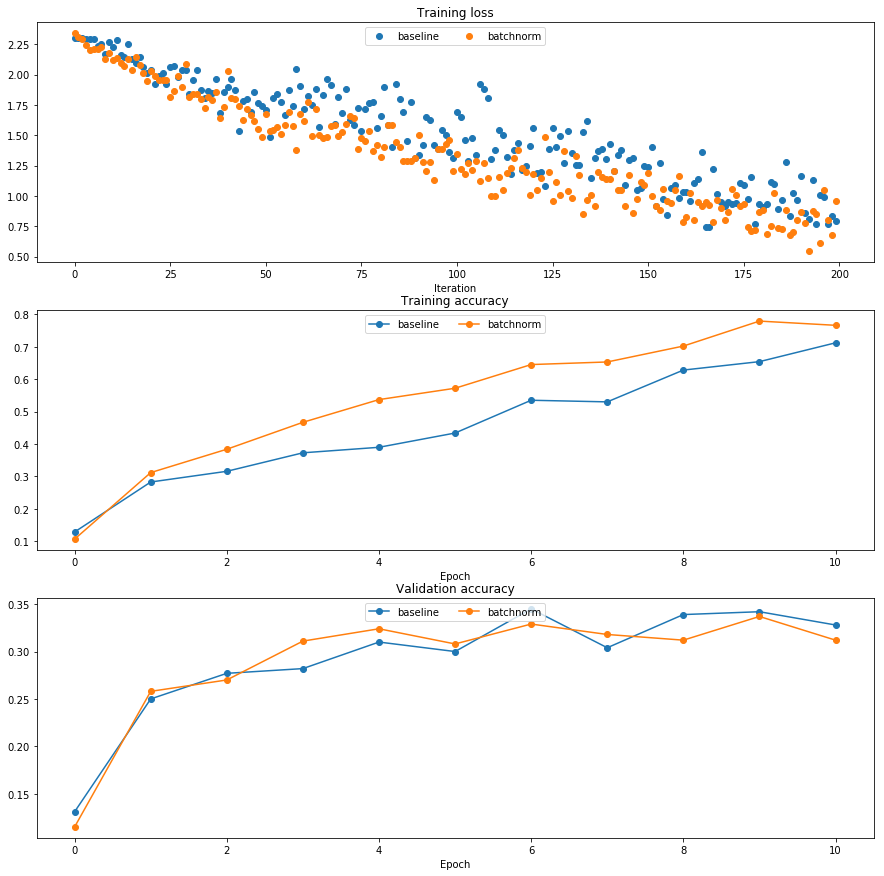

In [50]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [51]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


(1.0, 3.5)

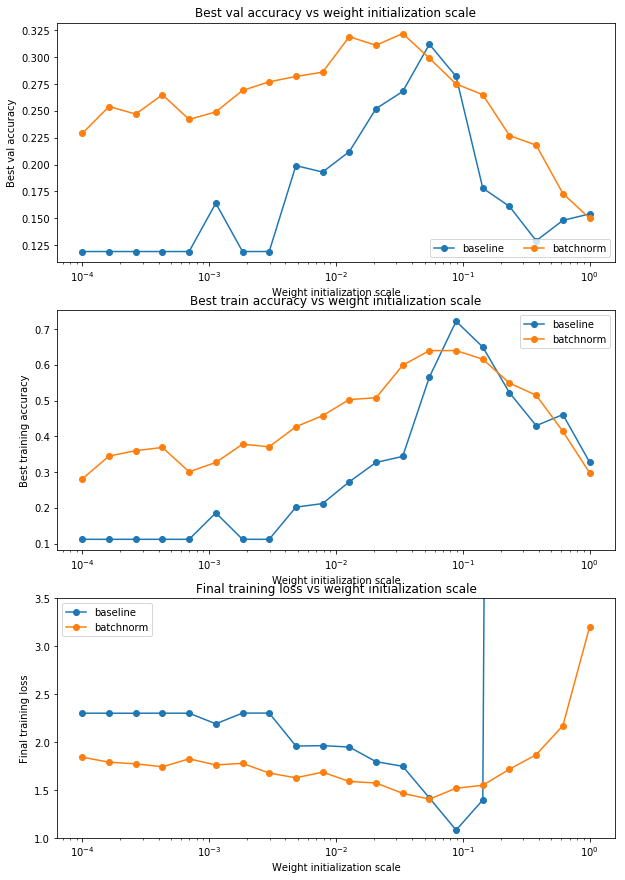

In [52]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 15)
plt.show()

# Question:
Describe the results of this experiment, and try to give a reason why the experiment gave the results that it did.

# Answer:
